In [9]:
import pymc3 as pm
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

%matplotlib inline

In [2]:
import sys
print('Python v{}'.format(sys.version))
print('PyMC3 v{}'.format(pm.__version__))
print('theano v{}'.format(theano.__version__))
print('numpy v{}'.format(np.__version__))

Python v3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
PyMC3 v3.5
theano v1.0.2
numpy v1.15.1


In [3]:
# Sampling parameters (watch out - the model takes a lot of time to run)
n_tune = 100
n_samples = 200
n_chains = 1
n_cores = 1

# Get data

In [4]:
n_seasons, n_TS, n_aliens, n_actions = 3, 3, 4, 3
n_trials, n_subj = 440, 30

# stimulus part 1
seasons = pd.read_csv("seasons.csv").values
# stimulus part 2
aliens = pd.read_csv("aliens.csv").values
# participants' selected actions
actions = pd.read_csv("actions.csv").values
# participants' received rewards
rewards = pd.read_csv("rewards.csv").values
# true underlying parameters
true_params = pd.read_csv("true_params.csv", header=0, index_col=0)

# Convert data to tensor variables
seasons = theano.shared(np.asarray(seasons, dtype='int32'))
aliens = theano.shared(np.asarray(aliens, dtype='int32'))
actions = theano.shared(np.asarray(actions, dtype='int32'))
rewards = theano.shared(np.asarray(rewards, dtype='int32'))
trials, subj = np.meshgrid(range(n_trials), range(n_subj))
trials = T.as_tensor_variable(trials.T)
subj = T.as_tensor_variable(subj.T)

# Run hierarchical RL model

In [5]:
# Set initial Q-value
alien_initial_Q = 1.2

# Define update function
rs = RandomStreams()
def update_Qs(season, alien, action, reward,
              Q_low, Q_high,
              beta, beta_high, alpha, alpha_high, forget, forget_high, n_subj, n_TS):

    # Select TS
    Q_high_sub = Q_high[T.arange(n_subj), season]  # Q_high_sub.shape -> [n_subj, n_TS]
    p_high = T.nnet.softmax(beta_high * Q_high_sub)
    # TS = season  # Comment in for classic RL model
    # TS = T.argmax(Q_high_sub, axis=1)  # Comment in for deterministic TS model
    rand = rs.uniform()   # Following 3 lines: Stochastic TS model
    cumsum = T.extra_ops.cumsum(p_high, axis=1)
    TS = n_TS - T.sum(rand < cumsum, axis=1)

    # Calculate action probabilities based on TS
    Q_low_sub = Q_low[T.arange(n_subj), TS, alien]  # Q_low_sub.shape -> [n_subj, n_actions]
    p_low = T.nnet.softmax(beta * Q_low_sub)

    # Forget Q-values a little bit
    Q_low = (1 - forget) * Q_low + forget * alien_initial_Q
    Q_high = (1 - forget_high) * Q_high + forget_high * alien_initial_Q

    # Calculate RPEs & update Q-values
    current_trial_high = T.arange(n_subj), season, TS
    RPE_high = reward - Q_high[current_trial_high]
    Q_high = T.set_subtensor(Q_high[current_trial_high],
                             Q_high[current_trial_high] + alpha_high * RPE_high)

    current_trial_low = T.arange(n_subj), TS, alien, action
    RPE_low = reward - Q_low[current_trial_low]
    Q_low = T.set_subtensor(Q_low[current_trial_low],
                            Q_low[current_trial_low] + alpha * RPE_low)

    return [Q_low, Q_high, TS, p_low]


In [6]:
with pm.Model() as model:

    # RL parameters: softmax temperature beta; learning rate alpha; forgetting of Q-values
    beta_shape = (n_subj, 1)  # Q_sub.shape inside scan -> [n_subj, n_actions]
    forget_shape = (n_subj, 1, 1, 1)  # Q_low.shape inside scan -> [n_subj, n_TS, n_aliens, n_actions]
    beta_high_shape = (n_subj, 1)  # Q_high_sub.shape inside scan -> [n_subj, n_TS]
    forget_high_shape = (n_subj, 1, 1)  # Q_high.shape inside scan -> [n_subj, n_seasons, n_TS]

    alpha_mu = pm.HalfNormal('alpha_mu', sd=0.1)
    alpha_sd = pm.HalfNormal('alpha_sd', sd=0.1)
    beta_mu = pm.Bound(pm.Normal, lower=0)('beta_mu', mu=1, sd=2)
    beta_sd = pm.HalfNormal('beta_sd', sd=1)
    forget_mu = pm.HalfNormal('forget_mu', sd=0.05)
    forget_sd = pm.HalfNormal('forget_sd', sd=0.05)

    alpha_high_mu = pm.HalfNormal('alpha_high_mu', sd=0.1)
    alpha_high_sd = pm.HalfNormal('alpha_high_sd', sd=0.1)
    beta_high_mu = pm.Bound(pm.Normal, lower=0)('beta_high_mu', mu=1, sd=2)
    beta_high_sd = pm.HalfNormal('beta_high_sd', sd=1)
    forget_high_mu = pm.HalfNormal('forget_high_mu', sd=0.05)
    forget_high_sd = pm.HalfNormal('forget_high_sd', sd=0.05)

    alpha = pm.Beta('alpha', mu=alpha_mu, sd=alpha_sd, shape=n_subj)
    beta = pm.Bound(pm.Normal, lower=0)('beta', mu=beta_mu, sd=beta_sd, shape=beta_shape)
    forget = pm.HalfNormal('forget', sd=forget_sd, shape=forget_shape)
#     forget = pm.Beta('forget', mu=forget_mu, sd=forget_sd, shape=forget_shape)  # what it should be 

    alpha_high = pm.Beta('alpha_high', mu=alpha_high_mu, sd=alpha_high_sd, shape=n_subj)
    beta_high = pm.Bound(pm.Normal, lower=0)('beta_high', mu=beta_high_mu, sd=beta_high_sd, shape=beta_shape)
    forget_high = pm.HalfNormal('forget_high', sd=forget_high_sd, shape=forget_high_shape)
#     forget_high = pm.Beta('forget_high', mu=forget_high_mu, sd=forget_high_sd, shape=forget_high_shape)  # what it should be

    # Calculate Q_high and Q_low for each trial
    Q_low0 = alien_initial_Q * T.ones([n_subj, n_TS, n_aliens, n_actions])
    Q_high0 = alien_initial_Q * T.ones([n_subj, n_seasons, n_TS])
    [Q_low, _, TS, p_low], _ = theano.scan(fn=update_Qs,
                                           sequences=[seasons, aliens, actions, rewards],
                                           outputs_info=[Q_low0, Q_high0, None, None],
                                           non_sequences=[beta, beta_high, alpha, alpha_high, forget, forget_high, n_subj, n_TS])

    # Relate calculated p_low to observed actions
    actions = pm.Categorical('actions',
                             p=p_low.reshape([n_trials * n_subj, n_actions]),
                             observed=actions.flatten())

    # MAP (fast, but less good results)
    map_estimate = pm.find_MAP()

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

In [7]:
# Nice plotting function
def plot_gen_rec(param_names, gen_rec):

    plt.figure()
    for i, param_name in enumerate(param_names):

        # Plot fitted parameters against true parameters
        plt.subplot(3, 3, i + 1)
        sns.regplot(gen_rec.loc[param_name], gen_rec.loc['true_' + param_name], fit_reg=False)
        y_max = np.max(gen_rec.loc['true_' + param_name])
        plt.plot((0, y_max), (0, y_max))

    # Plot fitted alpha * beta against recovered alpha * beta
    plt.subplot(3, 3, 8)
    sns.regplot(gen_rec.loc['alpha'] * gen_rec.loc['beta'], gen_rec.loc['true_alpha'] * gen_rec.loc['true_beta'], fit_reg=False)
    y_max = np.max(gen_rec.loc['true_alpha'] * gen_rec.loc['true_beta'])
    plt.plot((0, y_max), (0, y_max))
    plt.xlabel('alpha * beta')
    plt.ylabel('true alpha * beta')

    # Plot fitted alpha against fitted beta
    plt.subplot(3, 3, 9)
    sns.regplot(gen_rec.loc['alpha'], gen_rec.loc['beta'], fit_reg=False)

                    0          1         2          3          4         5   \
alpha         0.489194   0.579278  0.381070   0.452231   0.533042  0.142307   
beta         14.287762  22.355419  9.167198  10.554941  23.014103  2.306786   
forget        0.051130   0.026925  0.023493   0.041392   0.012522  0.012568   
alpha_high    0.076707   0.076707  0.076707   0.076707   0.076707  0.076707   
beta_high     1.000000   1.000000  1.000000   1.000000   1.000000  1.000000   
forget_high   0.030065   0.030065  0.030065   0.030065   0.030065  0.030065   

                   6         7         8         9     ...           20  \
alpha        0.045036  0.314135  0.332863  0.168898    ...     0.331113   
beta         0.510167  7.998705  6.718411  2.641070    ...     6.970572   
forget       0.050347  0.010137  0.033820  0.039283    ...     0.034424   
alpha_high   0.076707  0.076707  0.076707  0.076707    ...     0.076707   
beta_high    1.000000  1.000000  1.000000  1.000000    ...     1.000000

C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\indexes\api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)


                         0         1         2         3         4         5  \
true_alpha        0.152672  0.129882  0.187742  0.099413  0.082274  0.030081   
true_beta         4.285643  4.877344  3.795988  4.776514  3.224786  4.871333   
true_forget       0.052595  0.084212  0.060490  0.085872  0.000304  0.013963   
true_alpha_high   0.139735  0.092825  0.023401  0.119093  0.098691  0.028422   
true_beta_high    3.593482  4.256599  3.607054  3.944172  4.495977  4.531866   
true_forget_high  0.012632  0.014944  0.026859  0.096814  0.016878  0.062078   
alpha                  NaN       NaN       NaN       NaN       NaN       NaN   
beta                   NaN       NaN       NaN       NaN       NaN       NaN   
forget                 NaN       NaN       NaN       NaN       NaN       NaN   
alpha_high             NaN       NaN       NaN       NaN       NaN       NaN   
beta_high              NaN       NaN       NaN       NaN       NaN       NaN   
forget_high            NaN       NaN    

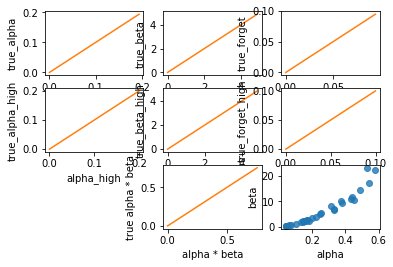

In [12]:
# Look at MAP results
param_names = ['alpha', 'beta', 'forget', 'alpha_high', 'beta_high', 'forget_high']
map_rec = pd.DataFrame([map_estimate[param_name].flatten() for param_name in param_names], index=param_names)
print(map_rec)
print(true_params)
map_gen_rec = true_params.append(map_rec)  # not working because '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
print(map_gen_rec)
plot_gen_rec(param_names=param_names, gen_rec=map_gen_rec)

Only 2 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\theano\tensor\subtensor.py:2190: FutureWarning: Usi

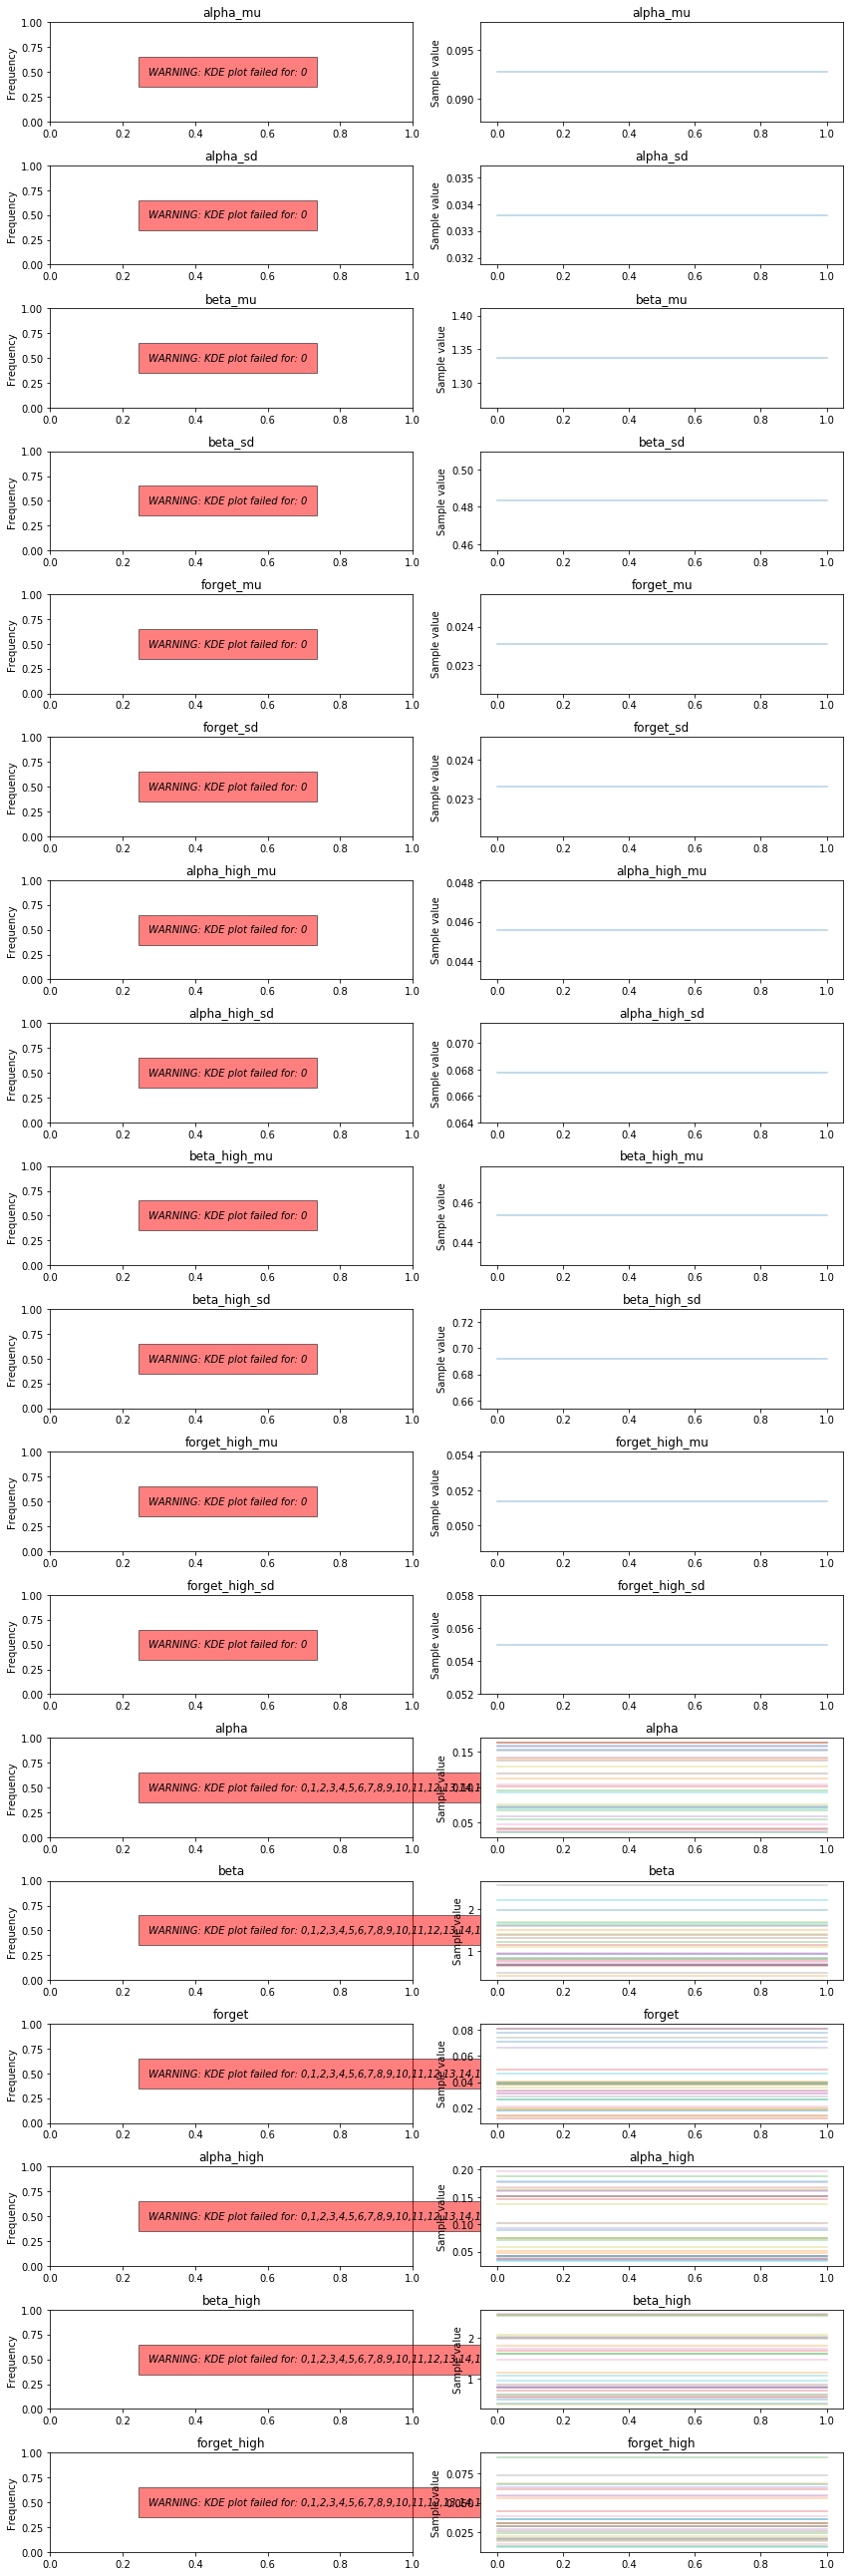

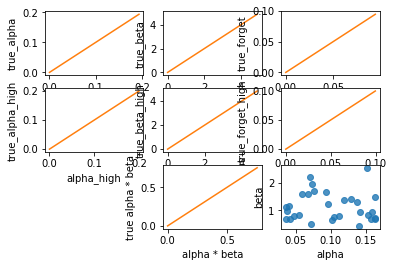

In [11]:
# Run MCMC samples (takes longer, but better results)
with model:
    MCMC_trace = pm.sample(n_samples, tune=n_tune, chains=n_chains, cores=n_cores)

# Look at MCMC results
MCMC_model_summary = pm.summary(MCMC_trace)
mcmc_params = np.full((len(param_names), n_subj), np.nan)
for i, param_name in enumerate(param_names):
    idxs = MCMC_model_summary.index.str.contains(param_name + '__')
    mcmc_params[i] = np.array(MCMC_model_summary.loc[idxs, 'mean'])
mcmc_params = pd.DataFrame(mcmc_params, index=param_names)
mcmc_gen_rec = true_params.append(mcmc_params)  # not working because '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects

pm.traceplot(MCMC_trace)
plot_gen_rec(param_names=param_names, gen_rec=mcmc_gen_rec)